# Building an inverted index

  - You are given a sample (1000 documents) from the [The Reuters-21578 data collection](http://www.daviddlewis.com/resources/testcollections/reuters21578/) in `data/reuters21578-000.xml`
  - The code that parses the XML and extract a list of preprocessed terms (tokenized, lowercased, stopwords removed) is already given
  - You are also given an `InvertedIndex` class that manages the posting lists operations
  - Your task is to build an inverted index from the input collection.

In [1]:
import ipytest
import re

from typing import List, Dict, Union, Any, Callable
from collections import Counter, defaultdict
from xml.dom import minidom
from dataclasses import dataclass

ipytest.autoconfig()

## Parsing documents

Stopwords list

In [2]:
STOPWORDS = ["a", "an", "and", "are", "as", "at", "be", "but", "by", "for", "if", "in", "into", "is", "it", "no", "not", "of", "on", "or", "such", "that", "the", "their", "then", "there", "these", "they", "this", "to", "was", "will", "with"]

Stripping tags inside <> using regex

In [3]:
def striptags(text: str) -> str:
    """Removes xml tags.

    Args:
        text: Text string with xml tags.

    Returns:
        String without xml tags.
    """
    p = re.compile(r"<.*?>")
    return p.sub("", text)

Parse input text and return a list of indexable terms

In [4]:
def parse(text: str) -> List[str]:
    """Parses documents and removes xml tags and punctuation.

    Args:
        text: Text to parse.

    Returns:
        List of tokens.
    """
    terms = []
    # Replace specific characters with space
    chars = ["'", ".", ":", ",", "!", "?", "(", ")"]
    for ch in chars:
        text = text.replace(ch, " ")

    # Remove tags
    text = striptags(text)

    # Tokenization
    # default behavior of the split is to split on one or more whitespaces
    return [term.lower() for term in text.split() if term not in STOPWORDS]

## Processing the input document collection

  - The collection is given as a single XML file.
  - Each document is inside `<REUTERS ...> </REUTERS>`.
  - We extract the contents of the `<DATE>`, `<TITLE>`, and `<BODY>` tags.
  - After each extracted document, the provided callback function is called and all document data is passed in a single dict argument.

In [5]:
def process_collection(input_file: str, callback: Callable) -> None:
    """Processes file and calls the callback function for each document in the
    file.

    Args:
        input_file: Path to file to process.
        callback: Function that will be called for each document.
    """
    xmldoc = minidom.parse(input_file)
    # Iterate documents in the XML file
    itemlist = xmldoc.getElementsByTagName("REUTERS")
    for doc_id, doc in enumerate(itemlist):
        date = doc.getElementsByTagName("DATE")[0].firstChild.nodeValue
        # Skip documents without a title or body
        if not (doc.getElementsByTagName("TITLE") and doc.getElementsByTagName("BODY")):
            continue
        title = doc.getElementsByTagName("TITLE")[0].firstChild.nodeValue
        body = doc.getElementsByTagName("BODY")[0].firstChild.nodeValue
        callback({
            "doc_id": doc_id+1,
            "date": date,
            "title": title,
            "body": body
            })

Prints a document"s contents (used as a callback function passed to `process_collection`)

In [6]:
def print_doc(doc: Dict[str, Union[str, int]]) -> None:
    """Print details of the first 5 documents.

    Args:
        doc: Dictionary with document details.
    """
    if doc["doc_id"] <= 5:  # print only the first 5 documents
        print("docID:", doc["doc_id"])
        print("date:", doc["date"])
        print("title:", doc["title"])
        print("body:", doc["body"])
        print("--")

In [7]:
!mkdir data
!wget --output-document="data/reuters21578-000.xml" "https://raw.githubusercontent.com/iai-group/ir-course-2022/main/resources/reuters21578-000.xml"

--2023-11-17 11:28:05--  https://raw.githubusercontent.com/iai-group/ir-course-2022/main/resources/reuters21578-000.xml
Risoluzione di raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connessione a raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 200 OK
Lunghezza: 1285303 (1,2M) [text/plain]
Salvataggio in: «data/reuters21578-000.xml»

data/reuters21578-0 100%[===================>]   1,23M  --.-KB/s    in 0,1s    

2023-11-17 11:28:05 (10,4 MB/s) - «data/reuters21578-000.xml» salvato [1285303/1285303]



In [8]:
process_collection("data/reuters21578-000.xml", print_doc)

docID: 1
date: 26-FEB-1987 15:01:01.79
title: BAHIA COCOA REVIEW
body: Showers continued throughout the week in
the Bahia cocoa zone, alleviating the drought since early
January and improving prospects for the coming temporao,
although normal humidity levels have not been restored,
Comissaria Smith said in its weekly review.
    The dry period means the temporao will be late this year.
    Arrivals for the week ended February 22 were 155,221 bags
of 60 kilos making a cumulative total for the season of 5.93
mln against 5.81 at the same stage last year. Again it seems
that cocoa delivered earlier on consignment was included in the
arrivals figures.
    Comissaria Smith said there is still some doubt as to how
much old crop cocoa is still available as harvesting has
practically come to an end. With total Bahia crop estimates
around 6.4 mln bags and sales standing at almost 6.2 mln there
are a few hundred thousand bags still in the hands of farmers,
middlemen, exporters and processors.
   

## Task 1: Complete the inverted index class

  - The inverted index is an object with methods for adding and fetching postings.
  - The data is stored in a map, where keys are terms and values are lists of postings.
  - Each posting is an object that holds the doc_id and an optional payload.

In [9]:
# Since this is a simple data class, intializing it can be abstracted with
# the use of dataclass decorator.
# https://docs.python.org/3/library/dataclasses.html

@dataclass
class Posting:
    doc_id: int
    payload: Any = None

In [10]:
class InvertedIndex:

    def __init__(self):
        self._index = defaultdict(list)

    def add_posting(self, term: str, doc_id: int, payload: Any=None) -> None:
        """Adds a document to the posting list of a term."""
        # append new posting to the posting list
        self._index[term].append(Posting(doc_id, payload))

    def get_postings(self, term: str) -> List[Posting]:
        """Fetches the posting list for a given term."""
        return self._index.get(term)

    def get_terms(self) -> List[str]:
        """Returns all unique terms in the index."""
        return self._index.keys()

    def write_to_file(self, filename_index: str) -> None:
        """Saves the index to a textfile."""
        with open(filename_index, "w") as f:
            for term, postings in self._index.items():
                f.write(term)
                for posting in postings:
                    f.write(f" {posting.doc_id}")
                    if posting.payload:
                        f.write(f":{str(posting.payload)}")
                f.write("\n")

Tests.

In [11]:
%%run_pytest[clean]

def test_postings():
    ind = InvertedIndex()
    ind.add_posting("term", 1, 1)
    ind.add_posting("term", 2, 4)
    # Testing existing term
    postings = ind.get_postings("term")
    assert len(postings) == 2
    assert postings[0].doc_id == 1
    assert postings[0].payload == 1
    assert postings[1].doc_id == 2
    assert postings[1].payload == 4
    # Testing non-existent term
    assert ind.get_postings("xyx") is None

def test_vocabulary():
    ind = InvertedIndex()
    ind.add_posting("term1", 1)
    ind.add_posting("term2", 1)
    ind.add_posting("term3", 2)
    ind.add_posting("term2", 3)
    assert set(ind.get_terms()) == set(["term1", "term2", "term3"])

..                                                                                           [100%]
2 passed in 0.01s


%%run_pytest[clean] and %%run_pytest are deprecated in favor of %%ipytest. %%ipytest will clean tests, evaluate the cell and then run pytest. To disable cleaning, configure ipytest with ipytest.config(clean=False).
ipytest.clean_tests is deprecated in favor of ipytest.clean


## Task 2: Build an inverted index from the input collection

**TODO**: Complete the code to index the entire document collection.  (The content for each document should be the title and body concatenated)

In [12]:
ind = InvertedIndex()

def index_doc(doc: Dict[str, Union[str, int]]) -> None:
    """Index document by concatenating document title and body.

    Args:
        doc: Document details.
    """
    text = doc["title"] + " " + doc["body"]
    terms = parse(text)  # list of terms in the document
    tc = Counter(terms)  # dict with term counts
    for term, freq in tc.items():
        ind.add_posting(term, doc["doc_id"], freq)

process_collection("data/reuters21578-000.xml", index_doc)

## Task 3: Save the inverted index to a file

Save the inverted index to a file (`data/index.dat`). Use a simple text format with `termID docID1:freq1 docID2:freq2 ...` per line, e.g.,

```
xxx 1:1 2:1 3:2
yyy 2:1 4:2
zzz 1:3 3:1 5:2
...
```

Implement this by (1) adding a `write_to_file(self, filename)` method to the `InvertedIndex` class and then (2) invoking that method in the cell below.

In [13]:
ind.write_to_file("data/index.dat")

## Task 4 (advanced, optional): Plot collection size against index size

Create a plot that compares the size of the document collection (bytes) against the size of the corresponding index (bytes) on the y-axis vs. with respect to the number of documents on the x-axis. You may use [Matplotlib](https://www.tutorialspoint.com/jupyter/jupyter_notebook_plotting.htm) for plotting.

In our solution, we create a different callback function and use that one for indexing.

In [14]:
import sys
import os

ind = InvertedIndex()
tmp_file = "data/index_tmp.dat"
stats = {
    "i": 0,
    "sum_bytes": 0,
    "num_docs": [],
    "size_index": [],
    "size_docs": []
}

def index_doc_with_stats(doc: Dict[str, Union[str, int]]) -> None:
    """Indexes documents and updates stats dictionary.

    Args:
        doc: [description]
    """
    index_doc(doc)
    # Stats are stored in a global variable (not very elegant but quick solution)
    stats["i"] += 1
    stats["sum_bytes"] += sys.getsizeof(str(doc))  # String document representation is a good proxy for doc size
    # We measure index size and document collection size after every 100 docs
    if stats["i"] % 100 == 0:
        stats["num_docs"].append(stats["i"])
        stats["size_docs"].append(stats["sum_bytes"])
        # To get index size, we dump it to a file and get file size
        # Alternatively, the pympler package may be used to measure the size of Python objects
        ind.write_to_file(tmp_file)
        stats["size_index"].append(os.path.getsize(tmp_file))

process_collection("data/reuters21578-000.xml", index_doc_with_stats)

In [15]:
import matplotlib.pyplot as plt

# Rendering plots inline in Jupyter notebooks.
%matplotlib inline

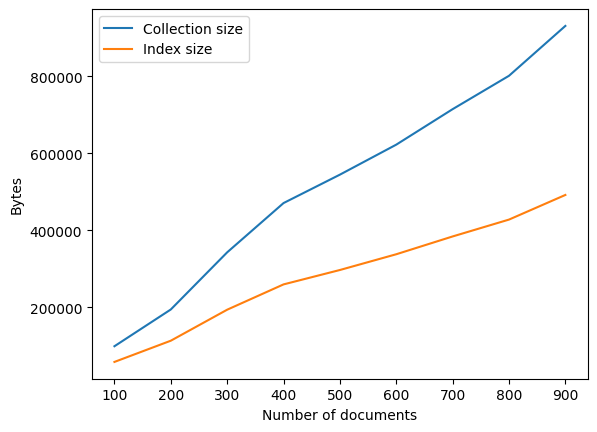

In [16]:
plt.plot(stats["num_docs"], stats["size_docs"], label="Collection size")
plt.plot(stats["num_docs"], stats["size_index"], label="Index size")
plt.xlabel("Number of documents")
plt.ylabel("Bytes")
plt.legend(loc="upper left")
plt.show()